### Group55 - Assignment 4 - Problem 4

In [1]:
#!pip install -U scikit-fuzzy

In [2]:
#Importing necessary libraries
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from IPython.display import Image

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

#### Given data
The following fuzzy quantities are defined, with their corresponding states:
>**D: Distance from obstacle**  -  N=Near, F=Far, VF=Very Far <br>
>**A: Angle with obstacle** -  S=Small, M=Medium, L=Large <br>
>**S: Speed** -  SS= Slow Speed, MS=Medium Speed, FS=Fast Speed, MX= Maximum Speed <br>
>**ST: Steering Turn** -  MST= Mild Turn, SST=Sharp Turn, VST= Very Sharp Turn <br>



| Fuzzy Quantity | Minimum Value | Maximum Value | Step |
| :-: | :-: | :-: | :-: |
| D | 0 | 10 | 0.5 |
| A | 0 | 90 | 1 |
| S | 0 | 5 | 0.2 |
| ST | 0 | 90 | 1 |


*source:* Assignment question

#### 1) Fuzzy Model Implementation

In [5]:
# Creating Antecedent/Consequent objects with the given scale
distance = ctrl.Antecedent(np.arange(0, 10.5, 0.5), 'distance')
angle = ctrl.Antecedent(np.arange(0, 91, 1), 'angle')
speed = ctrl.Consequent(np.arange(0, 5.2, 0.2), 'speed',defuzzify_method='mom')
steering = ctrl.Consequent(np.arange(0, 91, 1), 'steering',defuzzify_method='mom')

**a)** We are considering triangular membership functions for all the fuzzy quantities.<br>
The reason for choosing a simple linear membership function(trimf) was that the computational burden is reduced considerably and is very easy to tune.


In [6]:
distance['near'] = fuzz.trimf(distance.universe, [0, 0, 5])
distance['far'] = fuzz.trimf(distance.universe, [0, 5, 10])
distance['veryfar'] = fuzz.trimf(distance.universe, [5, 10,10])

angle['small'] = fuzz.trimf(angle.universe, [0, 0, 45])
angle['medium'] = fuzz.trimf(angle.universe, [0, 45, 90])
angle['large'] = fuzz.trimf(angle.universe, [45, 90,90])

speed['slowspeed'] = fuzz.trimf(speed.universe, [0, 0, 2])
speed['mediumspeed'] = fuzz.trimf(speed.universe, [1,2,3])
speed['fastspeed'] = fuzz.trimf(speed.universe, [2,3,4])
speed['maximumspeed'] = fuzz.trimf(speed.universe, [3,5,5])

steering['mildturn'] = fuzz.trimf(steering.universe, [0, 0, 45])
steering['sharpturn'] = fuzz.trimf(steering.universe, [0, 45, 90])
steering['verysharpturn'] = fuzz.trimf(steering.universe, [45, 90,90])

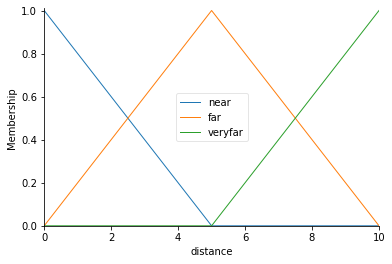

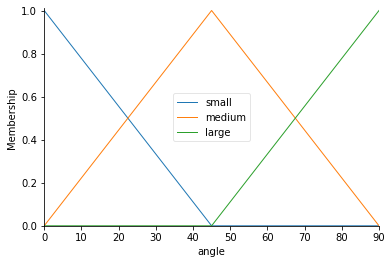

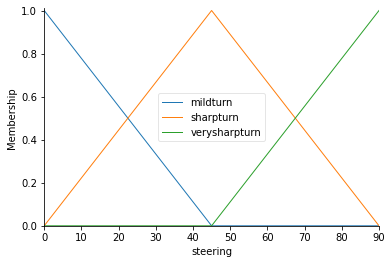

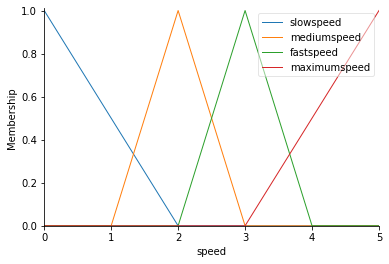

In [7]:
#Plotting the membership functions
distance.view()
angle.view()
steering.view()
speed.view()

#### **b)** Rule base:
We have created the rule base for fuzzy system. We made sure that the guide given below was included.
* When an obstacle is detected, avoid it: does not matter which direction; left or right
* When there is no obstacle move forward
* Speed is reduced when turning away from an obstacle
* Speed is increased when cruising (when there is no obstacle)

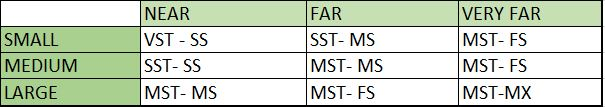

In [8]:
Image("RuleBase.jpg",width=500,height=100)

Creating the rules based on the rule base.

In [9]:
rule1 = ctrl.Rule(distance['near'] & angle['small'], (speed['slowspeed'],steering['verysharpturn']))
rule2 = ctrl.Rule(distance['near'] & angle['medium'], (speed['slowspeed'],steering['sharpturn']))
rule3 = ctrl.Rule(distance['near'] & angle['large'], (speed['mediumspeed'],steering['mildturn']))
rule4 = ctrl.Rule(distance['far'] & angle['small'], (speed['mediumspeed'],steering['sharpturn']))
rule5 = ctrl.Rule(distance['far'] & angle['medium'], (speed['mediumspeed'],steering['mildturn']))
rule6 = ctrl.Rule(distance['far'] & angle['large'], (speed['fastspeed'],steering['mildturn']))
rule7 = ctrl.Rule(distance['veryfar'] & angle['small'], (speed['fastspeed'],steering['mildturn']))
rule8 = ctrl.Rule(distance['veryfar'] & angle['medium'], (speed['fastspeed'],steering['mildturn']))
rule9 = ctrl.Rule(distance['veryfar'] & angle['large'], (speed['maximumspeed'],steering['mildturn']))

In [10]:
#Creating a Control System
speedandsteering_ctrl = ctrl.ControlSystem([rule1, rule2, rule3,rule4, rule5, rule6,rule7, rule8, rule9])

In [11]:
#Simulating the created control system
speedandsteering = ctrl.ControlSystemSimulation(speedandsteering_ctrl)

***
**c)** The inferencing system that will be used is **Mamdani**. <br>
**d)** The defuzzification method used is **Mean of Maxiums(MOM)**.<br>

**2)** Choices made:
* Mamdani fuzzy inference systems are used for MISO (Multiple Input Single Output) and MIMO (Multiple Input Multiple Output) systems. Sugeno fuzzy inference systems are used for MISO (Multiple Input Single Output) systems.

* We have to design an inference system with two antecedents (distance, angle) and two consequents (speed, steering turn) - a MIMO system and hence we are considering Mamdani system for implementation.

* The scikit-fuzzy controller is by default a mamdani system.

* The Centre of Area(CoA) defuzzification method would be used ideally in most of the scenarios. However, this is not an ideal method for a robot as it can lead to producing bad output values. For example, If the robot wants to move straight ahead and there is an obstacle in front, the robot can either move right or left. The output fuzzy set in this case would have two peaks – one on the right and the other on left. If COA method was used for defuzzification, an output which would take the robot even closer towards the target would be produced.
To overcome this problem, another technique mean of maximums(mom) is considered here.


***
#### 3) We are considering different values of 'distance' & 'angle' here and are observing the performance of fuzzy system

1) First case with an obstacle very near, distance=1 and angle with the obstacle small (10) <br>
As per the rule base, the robot has to slow down ('slow speed') and the steering turn has to be ('very sharp turn')

In [12]:
speedandsteering.input['distance'] = 1
speedandsteering.input['angle'] = 10

speedandsteering.compute()
print ('Speed of the robot: '+str(speedandsteering.output['speed']))
print ('Angle of the steering turn: '+str(speedandsteering.output['steering']))

Speed of the robot: 0.2611111111111112
Angle of the steering turn: 85.0


As expected the speed is SS:Slow speed (scale of slow speed: 0-2) and the steering turn is VST:very sharp(scale of steering turn angle: 45-90)
***

2) Second case where an obstacle is very far, distance=9 and the angle with obstacle to be 85('large') <br>
As per the rule base, the robot has to not slow down ('maximum speed') and the steering turn has to be ('mild turn')

In [13]:
data={'distance':9,'angle':85} 

speedandsteering.inputs(data)
#speedandsteering.input['angle'] = 90

speedandsteering.compute()
print ('Speed of the robot: '+str(speedandsteering.output['speed']))
print ('Angle of the steering turn: '+str(speedandsteering.output['steering']))

Speed of the robot: 4.800000000000001
Angle of the steering turn: 4.5


As expected the speed is at max (scale of max speed: 3-5) and the steering turn is very mild(scale of steering turn angle: 0-45)
***

3) A third case, where an obstacle is not very far and not near, and angle is 50. The robot has to travel with a medium speed with less or no steering turn.

In [14]:
data={'distance':5,'angle':50} 

speedandsteering.inputs(data)

speedandsteering.compute()
print ('Speed of the robot: '+str(speedandsteering.output['speed']))
print ('Angle of the steering turn: '+str(speedandsteering.output['steering']))

Speed of the robot: 2.0
Angle of the steering turn: 2.5


As expected the speed is medium (scale of speed: 1-3) and the steering turn is very mild(scale of angle: 0-45)
***

<br>
<br>
<br>




#### References
> Mamdani - https://github.com/scikit-fuzzy/scikit-fuzzy/pull/70
><br>
<br>
> Sugeno - https://github.com/scikit-fuzzy/scikit-fuzzy/issues/95
><br>
<br>
>https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.control.html#controlsystemsimulation
><br>
<br>
> https://github.com/scikit-fuzzy/scikit-fuzzy/issues/195
><br>
<br>
https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_tipping_problem_newapi.html
><br>
<br>
https://www2.cs.siu.edu/~hexmoor/classes/CS404-S08/fuzzy.pdf
